In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from tqdm.auto import tqdm
import requests
import json
import logging
logging.getLogger().setLevel("INFO")

Now that the basic calibration routines are in the microscope software, it's time to make use of them!  We've already got a ``move_in_image_coordinates`` function, but there is a lot more that can be done.

INFO:root:Connecting to microscope 192.168.0.48:5000
INFO:root:Error while changing resolution: Recording already running.
INFO:root:Error while starting preview: Recording already running.
Active microscope extensions
org.openflexure.autofocus
org.openflexure.autostorage
org.openflexure.camera_stage_mapping
org.openflexure.calibration.picamera
org.openflexure.scan
org.openflexure.zipbuilder
org.openflexure.dummy_task


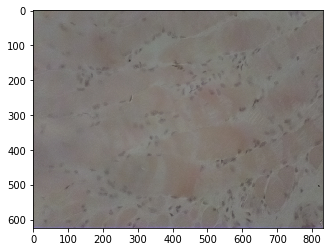

In [4]:
import microscope_client
from importlib import reload
reload(microscope_client)
microscope = microscope_client.find_first_microscope()

# Jiggle the stage to check it's all OK
pos = microscope.position
starting_pos = pos.copy()
pos['x'] += 100
microscope.move(pos)
assert microscope.position == pos
pos['x'] -= 100
microscope.move(pos)
assert microscope.position == starting_pos

# Check the microscope will autofocus
ret = microscope.autofocus()

# Acquire an image for sanity-checking too
image = microscope.grab_image()
f, ax = plt.subplots(1,1)
ax.imshow(np.array(image))
#print(image.metadata)
print("Active microscope extensions")
for k in microscope.extensions.keys():
    print(k)

# Calibrating the stage to the camera
Before we can do anything fancier, we need to make sure we understand the relationship between a step of the stage, and position in the image.  The next cell performs such a calibration.

In [3]:
cal = microscope.calibrate_xy()

INFO:root:Calibrating X axis:
INFO:root:Moving the stage until we see motion...
INFO:root:Moving the stage to the edge of the field of view...
INFO:root:Moving the stage backwards to measure backlash (1/2)
INFO:root:Moving the stage forwards to measure backlash (2/2)
INFO:root:Moving back to the start, correcting for backlash...
INFO:root:Estimated backlash 126 steps
INFO:root:Stage-to-image ratio 0.216 pixels/step
INFO:root:Residuals were about 0.04 times the step size
INFO:root:Calibrating Y axis:
INFO:root:Moving the stage until we see motion...
INFO:root:Moving the stage to the edge of the field of view...
INFO:root:Moving the stage backwards to measure backlash (1/2)
INFO:root:Moving the stage forwards to measure backlash (2/2)
INFO:root:Moving back to the start, correcting for backlash...
INFO:root:Estimated backlash 53 steps
INFO:root:Stage-to-image ratio 0.208 pixels/step
INFO:root:Residuals were about 0.04 times the step size
INFO:root:Updating settings with {'extensions': {'o

# Making a closed-loop move
In order to make a closed loop move of a bit less than one field of view, we should:
1. Calculate the expected overlap between the initial and final positions
1. Check the overlap is large enough (in future, this could trigger a multi-step move)
1. Take an initial image
1. Make the move (open loop for now, assuming we are fully-wound-up)
1. Take an image
1. Check the actual position by referencing the initial image against the image we just took
1. If we have not moved far enough, move a bit farther.

The problem comes if we've overshot, and I think the key is taking care of our tolerances.  Overshooting slightly in a tiled scan is not a big problem.  If we really need tight tolerances, we should do a combination of deliberately undershooting (moving a bit less than intended) and taking backlash into account when changing direction.

The cell below is just checking that ``ndimage.convolve`` uses higher precision in the convolution step - i.e. that we can use floating-point weights even if the image in and out is 8-bit.  I might just use floating point for now - but it's worth knowing for later, in case we need to optimise performance...

In [5]:
from camera_stage_tracker import Tracker, locate_feature_in_image
from scipy import ndimage

def high_pass_kernel(N, dimensions=2):
    assert N % 2 == 1, "Kernel dimensions must be odd!"
    k = np.zeros([N, N] + [1] * (dimensions - 2)) - 1
    k[(N-1)//2, (N-1)//2] = N**2 - 1
    return k / float(N)**2

test = np.ones((100,100,3), dtype=np.uint8)
test[4,0,0] = 255
print(test[0:10, 0, 0])
print("signed output: ", end="")
output = ndimage.convolve(test, high_pass_kernel(9, len(test.shape))/2, mode="nearest", output=np.int8)
print(output[0:10, 0, 0])
print("unsigned output (default): ", end="")
output = ndimage.convolve(test, high_pass_kernel(9, len(test.shape))/2, mode="nearest")
print(output[0:10, 0, 0])
print("floating point: ", end="")
output = ndimage.convolve(test, high_pass_kernel(9, len(test.shape))/2, mode="nearest", output=np.float)
print(output[0:10, 0, 0])

[  1   1   1   1 255   1   1   1   1   1]
signed output: [ -7  -7  -7  -7 119  -7  -7  -7  -7   0]
unsigned output (default): [249 249 249 249 119 249 249 249 249   0]
floating point: [ -7.83950617  -7.83950617  -7.83950617  -7.83950617 119.16049383
  -7.83950617  -7.83950617  -7.83950617  -7.83950617   0.        ]


## Figuring out correlation
My "find template" function relies on the template being small, which isn't ideal.  Instead, let's try a crosscorrelation approach.  First, we'll acquire a couple of test images.

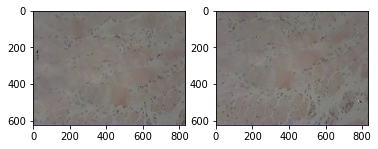

In [6]:
def move_in_pixels(x, y):
    microscope.extensions["org.openflexure.camera_stage_mapping"]["move_in_image_coordinates"].post_json({'x':x, 'y':y})

move_in_pixels(-100,-100)
move_in_pixels(100,100)
initial_image = microscope.grab_image_array()
move_in_pixels(100,100)
image_a = microscope.grab_image_array()
move_in_pixels(-100,-100)

f, ax = plt.subplots(1,2)
ax[0].imshow(initial_image)
ax[1].imshow(image_a)

Next, do some high pass filtering, so that any non-uniformity in the background won't be an issue.

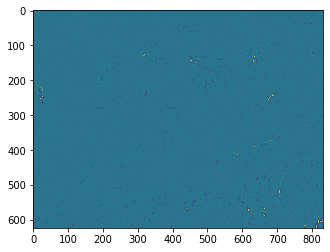

In [8]:
def overlapping_slice(shape, displacement, margin):
    slices = [None, None, ...]
    for i in range(2):
        d = displacement[i]
        s = shape[i]
        if d > 0:
            slices[i] = slice(max(0, d - margin), s)
        else:
            slices[i] = slice(0, min(s, s - d + margin))
    return slices

def high_pass_filter_and_grayscale(image, N=11):
    """Perform high pass filtering on an image"""
    assert image.dtype == np.uint8, "Currently, we only support 8-bit images"
    if len(image.shape) == 3:
        image = np.mean(image, axis=2, dtype=image.dtype)
    # Note the signed output, and the division by 2 to avoid overflow
    return ndimage.convolve(image, high_pass_kernel(N)/2, mode="nearest", output=np.int8)
 
f, ax = plt.subplots(1,1)
ax.imshow(high_pass_filter_and_grayscale(initial_image)/127)

Next, try some correlation.  This didn't seem to work and I don't really understand why.  When I run the correlate2d function, iPython hangs, which is obviously not helpful!

In [8]:
from scipy import signal
#corr = signal.correlate2d(high_pass_filter_and_grayscale(initial_image),
#                          high_pass_filter_and_grayscale(image_a),
#                          mode="same", boundary="symm")
#corr -= np.min(corr)
#corr /= np.max(corr)
#plt.imshow(corr)

Instead, let's do it with a nice efficient FFT.  This involves a few steps:
1. Convert to grayscale
1. Take the FFT (NB as the input is real, we may save some work by computing only one quadrant of the result, using ``np.fft.rfft2`` instead of the regular ``fft2``
1. Implement the high pass filter by zeroing out the low frequency components
1. Multiply the two FFT-ed images together
1. Perform the inverse transform

The Fourier filter possibly bears some explanation.  In image space, what we're doing is convolving the image with a Gaussian (to blur it), then subtracting the blurred image from the original.  That should remove the low frequency components, while preserving the high frequencies.  In Fourier space, the convolution becomes a multiplication, and the Gaussian

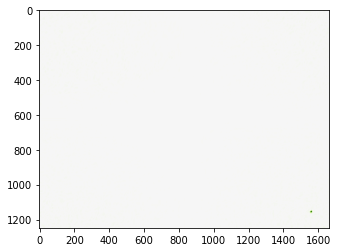

In [10]:
initial_gray = np.mean(initial_image, axis=2)
initial_gray -= initial_gray.mean()
initial_fft = np.fft.rfft2(initial_gray, s=np.array(initial_gray.shape)*2)  # NB rfft2 is faster, but a different shape!

def high_pass_fourier_mask(shape, s, rfft=True):
    """Generate a mask performing a high pass filter
    
    The return value is a 2D array, which can be multiplied
    with the Fourier Transform of an image to perform a high
    pass filter.
    
    Arguments:
        shape: tuple of 2 integers
            The shape of the output array
        s: float
            The standard deviation of the Gaussian in real
            space, """
    high_pass_filter = np.ones(shape)
    x, y = (np.arange(n, dtype=np.float) for n in shape)
    # Beyond the halfway point of the array, frequencies are negative
    x[x.shape[0]//2:x.shape[0]] -= x.shape[0]
    if not rfft: # If it's a real fft, the last axis is halved so we can skip this.
        y[y.shape[0]//2:y.shape[0]] -= y.shape[0]
    x /= np.max(np.abs(x)) * 2  # Normalise so highest frequency is 1/2
    y /= np.max(np.abs(y)) * 2  # Normalise so highest frequency is 1/2
    r2 = x[:, np.newaxis]**2 + y[np.newaxis, :]**2
    # now we multiply by 1-FT(Gaussian kernel with sd of s pixels)
    high_pass_filter -= np.exp(-2*np.pi**2*s**2*r2)
    return high_pass_filter

high_pass_filter = high_pass_fourier_mask(initial_fft.shape, 10)
    
gray_fft = np.fft.rfft2(np.mean(image_a, axis=2) - np.mean(image_a), s=np.array(initial_gray.shape)*2)

corr_fft = np.conj(initial_fft) * high_pass_filter * gray_fft
corr = np.fft.irfft2(corr_fft)

vmax = np.max(np.abs(corr))
f, ax = plt.subplots(1,1)
ax.imshow(np.abs(corr), cmap="PiYG", vmax=vmax, vmin=-vmax)

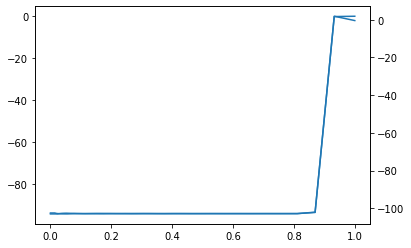

In [13]:
def background_subtracted_centre_of_mass(corr, fractional_threshold=0.05, quadrant_swap=False):
    """Carry out a background subtracted centre of mass measurement
    
    Arguments:
        corr: a 2D numpy array, to be thresholded
        fractional_threshold: the fraction of the range (from 
            min(corr) to max(corr)) that should remain above 
            the background level.  1 means no thresholding, 
            0.05 means use only the top 5% of the range.
    """
    assert corr.dtype == np.float, "The image must be floating point"
    background = np.max(corr) - fractional_threshold * (np.max(corr) - np.min(corr))
    background_subtracted = corr - background
    background_subtracted[background_subtracted < 0] = 0
    xs, ys = (np.arange(n) for n in corr.shape) # This is equivalent to meshgrid, more or less...
    if quadrant_swap:
        xs[len(xs)//2:] -= len(xs)
        ys[len(ys)//2:] -= len(ys)
    x = np.sum(background_subtracted * xs[:, np.newaxis])
    y = np.sum(background_subtracted * ys[np.newaxis, :])
    I = np.sum(background_subtracted)
    return x/I, y/I

ts = 10**np.linspace(0, -3, 100)
points = np.zeros((len(ts), 2))
for i, t in enumerate(ts):
    points[i, :] = background_subtracted_centre_of_mass(corr, t, True)
f, ax = plt.subplots(1,1)
ax.plot(ts, points[:,0])
ax.twinx().plot(ts, points[:,1])

# Thresholding check
As a useful sanity check, and an exercise in interactive plotting, the code below lets me vary the threshold, and see both the thresholded image, and the resulting position.

0

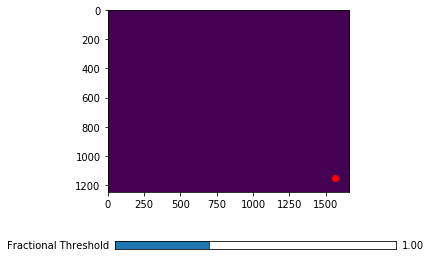

In [14]:
%matplotlib inline
from matplotlib.widgets import Slider, Button, RadioButtons
fig, ax = plt.subplots(1,1)
plt.subplots_adjust(bottom=0.25)

ax_thresh = plt.axes([0.25, 0.05, 0.65, 0.03])

    

slider_thresh = Slider(ax_thresh, 'Fractional Threshold', 0, 3, valinit=1, valstep=0.001)


def update(values):
    t = 10**(-slider_thresh.val)
    thresholded = corr.copy()
    background = np.max(corr) - t * (np.max(corr) - np.min(corr))
    thresholded[corr < background] = 0
    ax.cla()
    ax.imshow(thresholded, vmax=corr.max(), vmin=0)
    x, y = background_subtracted_centre_of_mass(corr, t)
    ax.plot(y, x, "o", color="red")
    fig.canvas.draw_idle()
update(None)
    
slider_thresh.on_changed(update)

To check we're getting an accurate reading, count the number of nonzero pixels - 100 would be nice, 1 is worrying.

In [15]:
t = 10**(-slider_thresh.val)
background = np.max(corr) - t * (np.max(corr) - np.min(corr))
print(f"There are {np.sum(corr >= background)} nonzero pixels")

There are 11 nonzero pixels


# Find the displacement between two images, with FFT
Putting the methods above together, we get:

In [16]:
def grayscale_and_padding(image, pad=True):
    """Convert to grayscale and prepare for zero padding if needed.
    
    The FFT-based tracking methods need grayscale images.  Also, if
    we are going to zero-pad, we should convert to floating point and
    ensure the mean of the image is zero, otherwise the dominant feature
    will be the edge of the image.
    
    Returns:
        image, fft_shape
    """
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)
    fft_shape = np.array(image.shape)
    if pad:
        image = image.astype(np.float) - np.mean(image)
        fft_shape *= 2
    return image, fft_shape
    
def high_pass_fft_template(image, sigma=10, pad=True):
    """Calculate a high-pass-filtered FT template for tracking
    
    This performs a real FFT, and then attenuates low frequencies.
    The resulting array can be used as a template for tracking.
    
    sigma is the standard deviation in pixels of the Gaussian  used
    in the high pass filter.
    
    pad enables (default) zero padding - this removes the ambiguity
    around position, at the cost of making the function slower.  We
    subtract the mean and zero-pad the input array (equivalent to 
    padding with the mean value, to reduce the impact of the edge)
    """
    image, fft_shape = grayscale_and_padding(image, pad)
    initial_fft = np.fft.rfft2(image, s=fft_shape)  # NB rfft2 is faster, but a different shape!
    high_pass_filter = high_pass_fourier_mask(initial_fft.shape, sigma)
    return np.conj(initial_fft) * high_pass_filter

def displacement_from_template(template, image, fractional_threshold=0.1, pad=True):
    """Find the displacement, in pixels, of an image from a template
    
    The template should be generated by ``high_pass_fft_template``
    Fractional_threshold is the fraction of the range (from max to min)
    of the cross-correlation image that should remain above the threshold
    before finding the peak by centre-of-mass.
    
    NB because of the periodic boundary conditions of the FFT, this gives
    a result that is ambiguous - it's only accurate modulo one image.  
    The result that is returned represents the smalles displacement,
    positive or negative.  You may add or subtract one whole image-width
    (or height) if that makes sense - use other cues to resolve the
    ambiguity.
    """
    image, fft_shape = grayscale_and_padding(image, pad)
    # The template is already Fourier transformed and high pass filtered.
    # so multiplying the two in Fourier space performs the convolution.
    corr = np.fft.irfft2(template * np.fft.rfft2(image, s=fft_shape))
    x, y = background_subtracted_centre_of_mass(corr, fractional_threshold, quadrant_swap=True)
    return x, y

def displacement_between_images(image_0, image_1, sigma=10, fractional_threshold=0.1, pad=True):
    """Calculate the displacement, in pixels, between two images."""
    return displacement_from_template(high_pass_fft_template(image_0, sigma, pad=pad), 
                                      image_1, fractional_threshold, pad=pad)

In [17]:
displacement_between_images(initial_image, image_a)

(-94.3005160548502, -102.81621068979348)

In [18]:
displacement_between_images(initial_image, initial_image)

(0.0, 0.0)

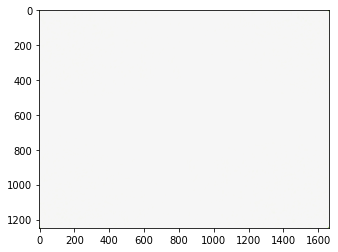

In [19]:
template = high_pass_fft_template(initial_image)
image, fft_shape = grayscale_and_padding(initial_image, True)
corr = np.fft.irfft2(template * np.fft.rfft2(image, s=fft_shape))

vmax = np.max(np.abs(corr))
f, ax = plt.subplots(1,1)
ax.imshow(np.abs(corr), cmap="PiYG", vmax=vmax, vmin=-vmax)

**Gotcha:** quadrant-swapping means that the blob can appear in all four corners at once, if we're very close to zero displacement!  An elegant solution would be to alter x and y in the CofM function to make this the centre...

# A simple test of our displacement sensor
To test this out, let's do a little experiment.  We'll take a template image, then move the stage in 10 steps of 50 pixels.  After doing this, we should have made it wrap - but hopefully it moves in the way we expect.  What we expect is that it should give an accurate result until we move by half the field of view (i.e. 316 pixels in y, or 212 in x), then "wrap" back by one whole image width/height.  After it's moved by almost a whole image, we expect that the signal is nonsense.

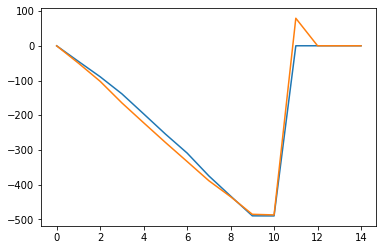

In [20]:
move_in_pixels(-100,-100)
move_in_pixels(100,100)

template = high_pass_fft_template(microscope.grab_image_array())
positions = [displacement_from_template(template, microscope.grab_image_array())]
for i in range(14):
    move_in_pixels(50, 50)
    positions.append(displacement_from_template(template, microscope.grab_image_array()))
move_in_pixels(-800,-800)
move_in_pixels(100,100)
positions = np.array(positions)
f, ax = plt.subplots(1,1)
ax.plot(positions[:,0])
ax.plot(positions[:,1])

## Putting it together
Now we've got reliable FT-based position tracking, we should be able to track the position, and auto-compensate for it ending up in slightly the wrong place.

In [45]:
from importlib import reload
import camera_stage_tracker
reload(camera_stage_tracker)
import fft_image_tracking
reload(fft_image_tracking)
from camera_stage_tracker import Tracker

In [53]:
from numpy.linalg import norm
def move_in_pixels_array(pos):
    move_in_pixels(int(pos[0]), int(pos[1]))

def closed_loop_move(tracker, move_in_pixels, pos, tolerance=5, max_iterations=3):
    """Move by a specified distance in pixels"""
    pos = np.array(pos)
    if not tracker.point_in_safe_range(pos):
        raise ValueError("closed_loop_move can only move by the maximum distance we can track.")
                  
    move_in_pixels(pos - tracker.image_positions[-1]) # Initial (open loop) move
    iterations = 0
    stage_pos, image_pos = tracker.append_point()
    while norm(image_pos - pos) > tolerance and iterations < max_iterations:
        move_in_pixels(pos - image_pos)
        stage_pos, image_pos = tracker.append_point()
        iterations += 1
        if iterations > max_iterations:
            logging.warn(f"Closed loop move did not converge in {max_iterations} iterations.")
            break
    return image_pos

                  

In [23]:
tracker = Tracker(microscope.grab_image_array, microscope.get_position_array, method="fft")
tracker.acquire_template()
closed_loop_move(tracker, move_in_pixels_array, (100, 100))
closed_loop_move(tracker, move_in_pixels_array, (100, -100))
closed_loop_move(tracker, move_in_pixels_array, (-100, -100))
closed_loop_move(tracker, move_in_pixels_array, (-100, 100))
closed_loop_move(tracker, move_in_pixels_array, (100, 100))
closed_loop_move(tracker, move_in_pixels_array, (0, 0))


array([2.41668272, 1.30745022])

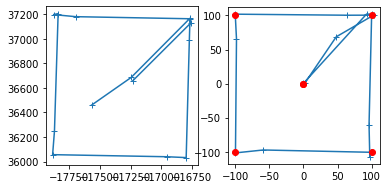

In [24]:
%matplotlib inline
f, ax = plt.subplots(1,2)
for positions, axes in zip(tracker.history, ax):
    axes.plot(positions[:,0], positions[:,1], "+-")
    axes.set_aspect(1)

ax[1].plot([0, 100, 100, -100, -100, 0], [0, 100, -100, -100, 100, 0], "ro")

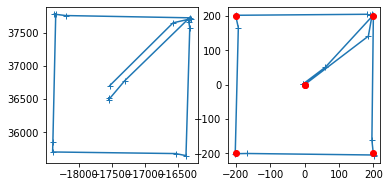

In [26]:
pos = np.array([200, 200])
tracker = Tracker(microscope.grab_image_array, microscope.get_position_array, method="fft")
tracker.acquire_template()
closed_loop_move(tracker, move_in_pixels_array, pos * [1, 1])
closed_loop_move(tracker, move_in_pixels_array, pos * [1, -1])
closed_loop_move(tracker, move_in_pixels_array, pos * [-1, -1])
closed_loop_move(tracker, move_in_pixels_array, pos * [-1, 1])
closed_loop_move(tracker, move_in_pixels_array, pos * [1, 1])
closed_loop_move(tracker, move_in_pixels_array, (0, 0))

f, ax = plt.subplots(1,2)
for positions, axes in zip(tracker.history, ax):
    axes.plot(positions[:,0], positions[:,1], "+-")
    axes.set_aspect(1)

ax[1].plot(np.array([0, 1, 1, -1, -1, 0]) * pos[0], np.array([0, 1, -1, -1, 1, 0]) * pos[1], "ro")

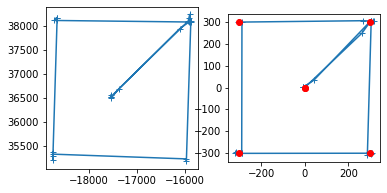

In [27]:
pos = np.array([300, 300])
tracker = Tracker(microscope.grab_image_array, microscope.get_position_array, method="fft")
tracker.acquire_template()
closed_loop_move(tracker, move_in_pixels_array, pos * [1, 1])
closed_loop_move(tracker, move_in_pixels_array, pos * [1, -1])
closed_loop_move(tracker, move_in_pixels_array, pos * [-1, -1])
closed_loop_move(tracker, move_in_pixels_array, pos * [-1, 1])
closed_loop_move(tracker, move_in_pixels_array, pos * [1, 1])
closed_loop_move(tracker, move_in_pixels_array, (0, 0))

f, ax = plt.subplots(1,2)
for positions, axes in zip(tracker.history, ax):
    axes.plot(positions[:,0], positions[:,1], "+-")
    axes.set_aspect(1)

ax[1].plot(np.array([0, 1, 1, -1, -1, 0]) * pos[0], np.array([0, 1, -1, -1, 1, 0]) * pos[1], "ro")

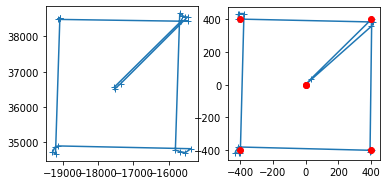

In [28]:
pos = np.array([400, 400])
tracker = Tracker(microscope.grab_image_array, microscope.get_position_array, method="fft", pad=True)
tracker.acquire_template()
closed_loop_move(tracker, move_in_pixels_array, pos * [1, 1])
closed_loop_move(tracker, move_in_pixels_array, pos * [1, -1])
closed_loop_move(tracker, move_in_pixels_array, pos * [-1, -1])
closed_loop_move(tracker, move_in_pixels_array, pos * [-1, 1])
closed_loop_move(tracker, move_in_pixels_array, pos * [1, 1])
closed_loop_move(tracker, move_in_pixels_array, (0, 0))

f, ax = plt.subplots(1,2)
for positions, axes in zip(tracker.history, ax):
    axes.plot(positions[:,0], positions[:,1], "+-")
    axes.set_aspect(1)

ax[1].plot(np.array([0, 1, 1, -1, -1, 0]) * pos[0], np.array([0, 1, -1, -1, 1, 0]) * pos[1], "ro")

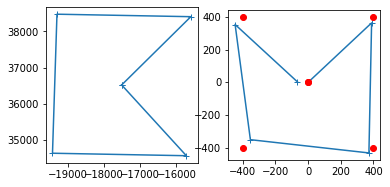

In [29]:
pos = np.array([400, 400])

tracker = Tracker(microscope.grab_image_array, microscope.get_position_array, method="fft", pad=True)
tracker.acquire_template()
current_pos = np.array([0,0])
move_in_pixels_array(pos * [1, 1] - current_pos)
current_pos = pos * [1, 1]
tracker.append_point()
move_in_pixels_array(pos * [1, -1] - current_pos)
current_pos = pos * [1, -1]
tracker.append_point()
move_in_pixels_array(pos * [-1, -1] - current_pos)
current_pos = pos * [-1, -1]
tracker.append_point()
move_in_pixels_array(pos * [-1, 1] - current_pos)
current_pos = pos * [-1, 1]
tracker.append_point()
move_in_pixels_array([0, 0] - current_pos)
tracker.append_point()

f, ax = plt.subplots(1,2)
for positions, axes in zip(tracker.history, ax):
    axes.plot(positions[:,0], positions[:,1], "+-")
    axes.set_aspect(1)

ax[1].plot(np.array([0, 1, 1, -1, -1, 0]) * pos[0], np.array([0, 1, -1, -1, 1, 0]) * pos[1], "ro")

INFO:root:moving to [0 0]
INFO:root:moving to [  0 300]
INFO:root:moving to [  0 600]
INFO:root:moving to [  0 900]
INFO:root:moving to [300 900]
INFO:root:moving to [300 600]
INFO:root:moving to [300 300]
INFO:root:moving to [300   0]
INFO:root:moving to [600   0]
INFO:root:moving to [600 300]
INFO:root:moving to [600 600]
INFO:root:moving to [600 900]
INFO:root:moving to [900 900]
INFO:root:moving to [900 600]
INFO:root:moving to [900 300]
INFO:root:moving to [900   0]


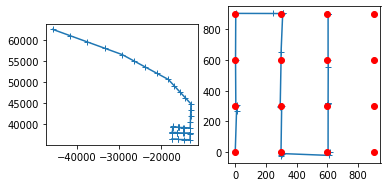

In [56]:
spacing = np.array((300,300))
N = 4
snake_path = []
for i in range(N):
    line = [(i, j) * spacing for j in range(N)]
    if i % 2 > 0:
        line = reversed(line)
    snake_path += line

tracker = cst.Tracker(microscope.grab_image_array, microscope.get_position_array, method="fft", pad=True)
tracker.acquire_template()
initial_position = tracker.stage_positions[-1]

for p in snake_path:
    logging.info(f"moving to {p}")
    closed_loop_move(tracker, move_in_pixels_array, p)
    tracker.leapfrog()

microscope.move(initial_position)

f, ax = plt.subplots(1,2)
for positions, axes in zip(tracker.history, ax):
    axes.plot(positions[:,0], positions[:,1], "+-")
    axes.set_aspect(1)

snake_path = np.array(snake_path)

ax[1].plot(snake_path[:,0], snake_path[:,1], "ro")


In [39]:
microscope.move(initial_position)


{'x': -17516, 'y': 36519, 'z': 1174}

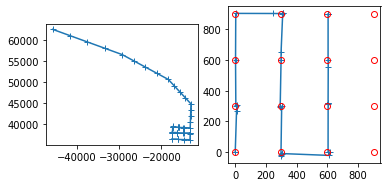

In [57]:
f, ax = plt.subplots(1,2)
for positions, axes in zip(tracker.history, ax):
    axes.plot(positions[:,0], positions[:,1], "+-")
    axes.set_aspect(1)

snake_path = np.array(snake_path)

ax[1].plot(snake_path[:,0], snake_path[:,1], "ro", fillstyle="none")

## Checking where zero is in the image tracking code
It would save a bunch of headaches if we could guarantee that the two tracking methods would both return zero if you give the same image to them as template and target...

The image, un-displaced, is now at [ 0.02644335 -0.00660373]


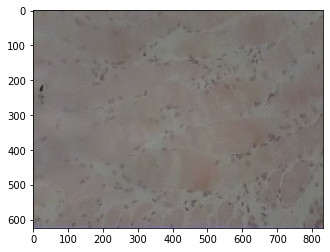

In [55]:
import camera_stage_tracker as cst
reload(cst)
plt.imshow(initial_image)
ccor_pos = cst.locate_feature_in_image(initial_image, cst.central_half(initial_image), relative_to="centre")
print(f"The image, un-displaced, is now at {ccor_pos}")

Everything works nicely, until the tracking fails and we go haywire.  What would be great is a sanity check on the tracking.  Possibly just checking that the error we've detected isn't too big would be a good start (how big is too big?), but I thought it would be nice to do a quick sanity check on the centre of mass measurement.  Together with Ed, we discussed two sensible strategies:
* vary the threshold, and check for convergence
* keep the threshold fixed but check the points above the threshold are close together

Another sensible strategy might be to predict what the maximum signal we'd expect is (i.e. when we set the template, do a tracking step and calculate the maximum signal).  That has the advantage of nearly zero marginal cost in speed, so let's try that for now.

We can test it out by moving the stage and tracking the correlation score; it should drop off more or less linearly with the area overlap between the template image and the final image.

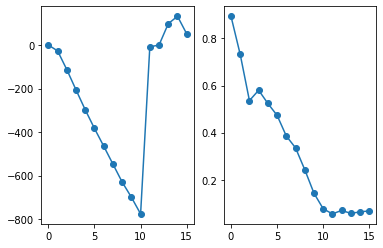

In [66]:
import fft_image_tracking as ft
reload(ft)
template = ft.high_pass_fft_template(microscope.grab_image_array())
scores = []
positions = []

starting_pos = microscope.get_position_array()
for i in range(16):
    if i>0:
        move_in_pixels(0, 80)
    pos, s = ft.displacement_from_fft_template(template, microscope.grab_image_array(), return_peak=True)
    positions.append(pos)
    scores.append(s)

microscope.move(starting_pos)

positions = np.array(positions)

f, ax = plt.subplots(1,2)
ax[0].plot(positions[:,1], 'o-')
ax[1].plot(scores/template.attrs["maximum_correlation_value"], 'o-')

Now, let's repeat that with error-detection:

INFO:root:moving to [0 0]
INFO:root:moving to [  0 300]
INFO:root:moving to [  0 600]
INFO:root:moving to [  0 900]
INFO:root:moving to [300 900]
INFO:root:moving to [300 600]
INFO:root:moving to [300 300]
INFO:root:moving to [300   0]
INFO:root:moving to [600   0]
INFO:root:moving to [600 300]
INFO:root:moving to [600 600]
INFO:root:moving to [600 900]
INFO:root:moving to [900 900]
The correlation signal dropped below the threshold set.


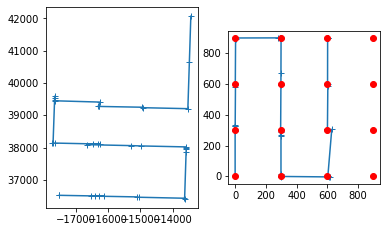

In [68]:
reload(cst)
spacing = np.array((300,300))
N = 4
snake_path = []
for i in range(N):
    line = [(i, j) * spacing for j in range(N)]
    if i % 2 > 0:
        line = reversed(line)
    snake_path += line

tracker = cst.Tracker(microscope.grab_image_array, microscope.get_position_array, method="fft", pad=True, error_threshold=0.2)
tracker.acquire_template()
initial_position = tracker.stage_positions[-1]

try:
    for p in snake_path:
        logging.info(f"moving to {p}")
        closed_loop_move(tracker, move_in_pixels_array, p)
        tracker.leapfrog()
except cst.TrackingError as e:
    print(e)
finally:
    microscope.move(initial_position)

f, ax = plt.subplots(1,2)
for positions, axes in zip(tracker.history, ax):
    axes.plot(positions[:,0], positions[:,1], "+-")
    axes.set_aspect(1)

snake_path = np.array(snake_path)

ax[1].plot(snake_path[:,0], snake_path[:,1], "ro")


It would be nice if I'd broken this up into individual moves, so I could record the position each image would have been taken at...

Without correction, RMS error was 29.412652307259204 pixels.
After correction, RMS error was 2.9269593095966555 pixels.


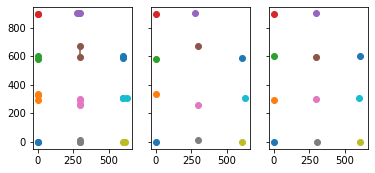

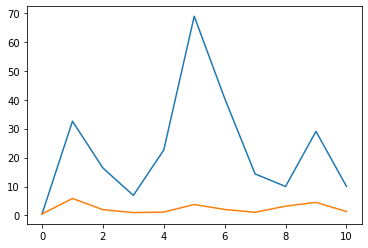

In [82]:
stage_pos, camera_pos = tracker.history
moves = []
move_indices = np.zeros(camera_pos.shape[0], dtype=int)
for i in range(camera_pos.shape[0]):
    move_indices[i] = np.argmin(np.sum((snake_path - camera_pos[i,:])**2, axis=1))

# move_indices should be monotonic, starting at the first index and moving to the next
# until we're done.
assert np.min(move_indices) == 0
assert np.all(np.diff(move_indices) >= 0)
assert np.all(np.diff(move_indices) <= 1)

for i in range(np.max(move_indices)):
    moves.append(camera_pos[move_indices==i, :])

f, ax = plt.subplots(1,3, sharex=True, sharey=True)

initial_errors = np.zeros(len(moves))
final_errors = np.zeros(len(moves))
for i, m in enumerate(moves):
    ax[0].plot(m[:,0], m[:,1], "o-")
    ax[1].plot(m[0,0], m[0,1], "o-")
    ax[2].plot(m[-1,0], m[-1,1], "o-")
    initial_errors[i] = np.sum((snake_path[i,:] - m[0])**2)**0.5
    final_errors[i] = np.sum((snake_path[i,:] - m[-1])**2)**0.5

for axis in ax:
    axis.set_aspect(1)

f, ax = plt.subplots(1,1)
ax.plot(initial_errors)
ax.plot(final_errors)

print(f"Without correction, RMS error was {np.mean(initial_errors**2)**0.5} pixels.")
print(f"After correction, RMS error was {np.mean(final_errors**2)**0.5} pixels.")